# Quick Intro to JAX

JAX is a python library for automatic differentiation. There is by now quite a lot of well-presented material about JAX available online; [the JAX docs](https://jax.readthedocs.io/en/latest/) are generally very accessible and helpful, and there are also some excellent tutorials floating around (I particularly like [this one](https://ericmjl.github.io/dl-workshop/index.html) on Differentiable Programming with JAX). This notebook just gives a quick overview of some of the core features in JAX: `jax.numpy`, `jax.jit`, `jax.grad`, and `jax.vmap`.

## JAX as Numpy that runs on GPUs

The JAX API will be familiar to people used to performing bulk-array calculations with Numpy. Even when not using autodiff, writing Numpy-like programs in JAX is a great way to write fast python code that targets GPUs, since JAX's backend is the [XLA](https://www.tensorflow.org/xla) library for accelerated linear algebra. As they say in the JAX docs, you can think of JAX as a differentiable Numpy that runs on accelerators. JAX provides its own implementation of most of the functionality in Numpy, using the same syntax:

In [1]:
from jax import numpy as jnp

nx = 30
xarr = jnp.linspace(0, 2*jnp.pi, nx)
yarr = jnp.cos(xarr)

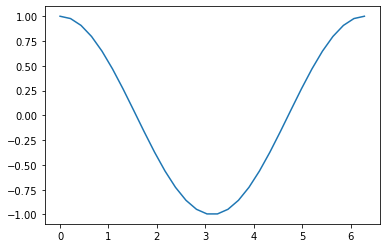

In [2]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
__=ax.plot(xarr, yarr)

In [3]:
xarr

DeviceArray([0.        , 0.21666157, 0.43332314, 0.6499847 , 0.8666463 ,
             1.0833079 , 1.2999694 , 1.516631  , 1.7332926 , 1.9499542 ,
             2.1666157 , 2.3832774 , 2.5999389 , 2.8166003 , 3.033262  ,
             3.2499237 , 3.4665852 , 3.6832466 , 3.8999083 , 4.11657   ,
             4.3332314 , 4.549893  , 4.766555  , 4.9832163 , 5.1998777 ,
             5.416539  , 5.6332006 , 5.8498626 , 6.066524  , 6.2831855 ],            dtype=float32)

Notice how `xarr` shows up as a "DeviceArray". This is our first indicator that JAX targets GPUs. In GPU programming, one of the primary performance concerns is minimizing transfers of data from CPU to GPU memory; the default behavior of JAX is "lazy", so that whenever possible, JAX never returns data from the GPU back to the CPU unless requested, such as the above print statement. This is especially convenient because it means you don't need to rewrite your code to gain major performance benefits from running your programs on a GPU-accelerated machine.

## Fast code using JAX's just-in-time compiler

Under the hood, JAX builds a computational trace of all the JAX operations that will be performed during the execution of a function. This trace is used by JAX in gradient calculations with autodiff, and but also more generally to map python code onto a set of array transformations that are efficient to evaluate using the core linear algebra transformations in XLA. This is true for the `jax.numpy` functions above, and also for custom functions you write yourself that use the `jax.jit` decorator to compile the function.

First let's define a simple python function and time it:

In [4]:
def func(x):
    for i in range(10):
        x = x - i*0.1*x + i*i
    return np.mean(x[:100])

In [5]:
import numpy as np

xarr_timeit = np.random.uniform(0, 1, int(1e6))

In [6]:
%timeit func(xarr_timeit)

45.5 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### The `@jax.jit` decorator

Now let's use `jax.jit` to build a fast-evaluating compiled version of our function. `jax.jit` is a _decorator_, so it accepts a function as input and returns another function. In our case, `jax.jit` accepts a slow pure-python version of our function, and the function we get back is a fast-evaluating version that gets compiled down to XLA. The phrase "just-in-time" just means that this compilation will not happen until the first time we actually call the function. 

You can use `jax.jit` with functional syntax like this: `new_func = jax.jit(orig_func)`.

Or you can adorn your function with the decorator syntax `@jax.jit` like in the cell below.

In [7]:
from jax import jit as jjit

@jjit
def jax_func(x):
    for i in range(10):
        x = x - i*0.1*x + i*i
    return jnp.mean(x[:100])

In [8]:
jax_func(xarr_timeit)

DeviceArray(88.68429, dtype=float32)

In [9]:
%timeit jax_func(xarr_timeit)

792 µs ± 152 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## But wait, there are some gotchas

In many situations, speeding up your code and making it GPU portable is as simple as the above examples. But there are some gotchas to be aware of, in which you need to implement your code in a particular way in order for JAX to be able to compile it. This is written about extensively in [this section of the JAX docs](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html); here I'll only cover a couple of commonly encountered examples.

First of all, it's necessary to write "pure functions" whose behavior is free of side-effects: the returned values of your function cannot depend on a mutable state defined elsewhere in the program. This is because at compile-time, JAX builds a computational trace of the flow of data through your function, which requires that your function must have deterministic behavior w/r/t each of its arguments. This is why libraries and programs based on JAX tend to be written in a functional style, since this make it simpler to guarantee that we only ever ask JAX to apply its transformations on side-effect-free functions. This can take some getting used to if you're more familiar with object-oriented machine learning libraries like `scikit-learn`, `pytorch` and `tensorflow`. The pure-function requirement of JAX requires you to implement _everything_ in JAX in order to use `jax.jit`. The behavior of your function cannot arbitrarily depend on some other external library such as `numpy` or `scipy`. That brings us to Gotcha #1.

### Gotcha 1: Everything inside a jitted function must be implemented in JAX

In [10]:
from scipy.special import erf as erf_scipy


@jjit
def jax_func_whoops(x):
    return erf_scipy(x) + x**2

In [11]:
xarr = np.linspace(0, 2*np.pi, nx)

In [12]:
jax_func_whoops(xarr)

TracerArrayConversionError: ignored

The error message is telling us that the input argument `x` depends upon `scipy.special.erf` and so the function cannot be traced. But JAX has its own implementations of a portion of the functions in the `scipy` library as well. The cell below instead uses the JAX version of this same function.

In [13]:
from jax.scipy.special import erf as erf_jax


@jjit
def jax_func_roger(x):
    return erf_jax(x) + x**2

In [14]:
jax_func_roger(xarr)

DeviceArray([ 0.        ,  0.28764644,  0.6477679 ,  1.0644981 ,
              1.530735  ,  2.0480406 ,  2.6239219 ,  3.2682035 ,
              3.9900665 ,  4.796499  ,  5.69204   ,  6.67926   ,
              7.7594447 ,  8.933169  , 10.200659  , 11.561998  ,
             13.01721   , 14.566305  , 16.209284  , 17.946144  ,
             19.776896  , 21.701525  , 23.720041  , 25.83244   ,
             28.038723  , 30.338898  , 32.73295   , 35.220886  ,
             37.802708  , 40.47842   ], dtype=float32)

### Gotcha 2: JAX arrays are immutable

Another feature to be aware of is that you cannot do in-place operations on a JAX DeviceArray. That means that the same syntax you may be used to with numpy indexing arrays is not supported by JAX, and a different syntax is required. The few cells below give a common example.

In [15]:
def numpy_clip_allgood(x):
    msk = x < 0.5
    x[msk] = 0.5
    return x

In [16]:
numpy_clip_allgood(xarr)

array([0.5       , 0.5       , 0.5       , 0.64998469, 0.86664625,
       1.08330781, 1.29996937, 1.51663094, 1.7332925 , 1.94995406,
       2.16661562, 2.38327719, 2.59993875, 2.81660031, 3.03326187,
       3.24992343, 3.466585  , 3.68324656, 3.89990812, 4.11656968,
       4.33323125, 4.54989281, 4.76655437, 4.98321593, 5.1998775 ,
       5.41653906, 5.63320062, 5.84986218, 6.06652374, 6.28318531])

The Numpy function above just clips its input array from below at 0.5. The line `x[msk] = 0.5` modifies the array `x` in-place, but JAX DeviceArrays are immutable, and so this operation is not supported.

In [17]:
@jjit
def jax_clip_whoops(x):
    msk = x < 0.5
    x[msk] = 0.5
    return x

In [18]:
jax_clip_whoops(xarr)

TypeError: ignored

A common code pattern to address this kind of calculation is to use the `jnp.where` function as below.

In [20]:
@jjit
def jax_clip_roger(x):
    msk = x < 0.5
    y = jnp.where(msk, x - 1.0, x)
    return y

In [21]:
jax_clip_roger(xarr)

DeviceArray([0.5       , 0.5       , 0.5       , 0.64998466, 0.86664623,
             1.0833079 , 1.2999693 , 1.5166309 , 1.7332925 , 1.949954  ,
             2.1666157 , 2.3832772 , 2.5999386 , 2.8166003 , 3.0332618 ,
             3.2499235 , 3.466585  , 3.6832466 , 3.899908  , 4.1165695 ,
             4.3332314 , 4.549893  , 4.7665544 , 4.983216  , 5.1998773 ,
             5.416539  , 5.6332006 , 5.849862  , 6.0665236 , 6.2831855 ],            dtype=float32)

In [22]:
from jax.lax import cond

## Computing gradients with `jax.grad`

The cell below shows how to use the autodiff functionality of JAX to calculate the derivative of an input function. The `jax.grad` transformation accepts a input function $f$ and returns a function $f'$ that computes the derivative of $f$.

In [23]:
from jax import grad

sin_deriv = jjit(grad(jnp.sin))

np.cos(np.pi/8), sin_deriv(np.pi/8)

(0.9238795325112867, DeviceArray(0.9238795, dtype=float32, weak_type=True))

Whether the cosine function is implemented via `np.cos` or via the autodiff-calculated gradient of the sin function, the results agree to `float32` precision.

The code above evaluated `sin_deriv` with a scalar value $x=\pi/8$. Now let's try calculating the gradients for an array of inputs:

In [24]:
cos_result_numpy = np.cos(xarr)

In [25]:
cos_result_jax = sin_deriv(xarr)

TypeError: ignored

The function input to `jax.grad` must return a scalar, not an array. To efficiently evaluate the gradient of a function for arrays, we need to use the `jax.vmap` function.

## Vectorizing functions with `jax.vmap`


The `jax.vmap` function accepts transforms the behavior of an input function to operate on arrays of its inputs and to return result arrays of higher dimension. The gradient of the sin function we wrote above accepts and returns scalars, so we can use `jax.vmap` to transform this function to accept and return one-dimensional arrays.

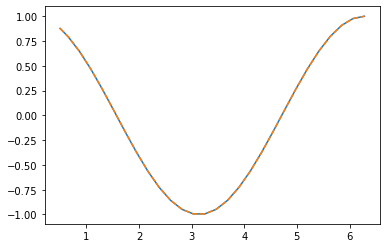

In [26]:
from jax import vmap 

sin_deriv_vmap = jjit(vmap(grad(jnp.sin)))

cos_result_jax = sin_deriv_vmap(xarr)

fig, ax = plt.subplots(1, 1)
__=ax.plot(xarr, cos_result_numpy)
__=ax.plot(xarr, cos_result_jax, '--')

### `jax.vmap` in multiple dimensions

The example of `jax.vmap` above showed how to transform a scalar-valued function into a function that accepts and returns 1d vectors. This same vectorization transformation can be used to construct higher-dimensional operations by composing successive vmap calls.

First we define a $f(x, A, B)=A{\rm sin}(Bx)$, and then use `jax.grad` to define a new function that calculates $\partial f/\partial x$.

Note that we now pass the `argnums` keyword argument to `jax.grad` to specify that we gradient we are interested in is with respect to the first positional argument, $x.$

In [27]:
@jjit
def some_func(x, a, b):
    return a*jnp.sin(b*x)


some_func_deriv = jjit(grad(some_func, argnums=0))

The function `some_func_deriv` is defined as $\frac{\partial}{\partial x} A\cdot{\rm sin}(B\cdot x)=A\cdot B\cdot{\rm cos}(B\cdot x).$ We have defined `some_func_deriv` based on `jax.grad`, and so it accepts scalars for all its arguments and returns a scalar. We can use the `in_axes` keyword argument of `jax.vmap`  to get the corresponding function that accepts an array input for its first argument, `x`, and scalars for the remaining two input arguments, `a` and `b`. For the `in_axes` argument you pass in a tuple with one entry for each positional argument, using a `0` for the entry of an argument that you want vectorized, and `None` for arguments whose form should remain unchanged.

In [28]:
some_func_deriv_vmap0 = jjit(vmap(some_func_deriv, in_axes=(0, None, None)))

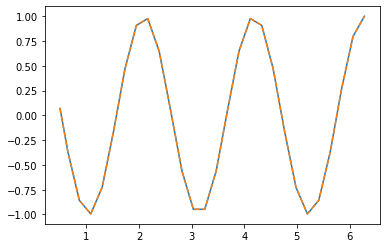

In [29]:
fig, ax = plt.subplots(1, 1)

a, b = 1/3, 3
__=ax.plot(xarr, some_func_deriv_vmap0(xarr, a, b))
__=ax.plot(xarr, a*b*np.cos(b*xarr), '--')

We can use `vmap` again if we want to construct a function that accepts an array for the input argument `a`

In [30]:
some_func_deriv_vmap1 = jjit(vmap(some_func_deriv_vmap0, in_axes=(None, 0, None)))

In [31]:
n_a = 5
a_arr = np.linspace(1, 10, n_a)
result = some_func_deriv_vmap1(xarr, a_arr, b)
result.shape

(5, 30)

Notice that the returned dimension is `(n_a, n_x)`. This would be flipped if we had applied our vmapping in the reverse order. Each new vmapped argument(s) appears as the first dimension of the returned shape. 

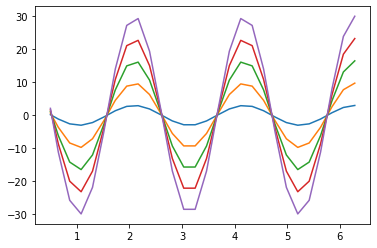

In [32]:
fig, ax = plt.subplots(1, 1)
for ia in range(result.shape[0]):
    __=ax.plot(xarr, result[ia, :])

Using `vmap` once more we can vectorize the `b` argument

In [33]:
some_func_deriv_vmap2 = jjit(vmap(some_func_deriv_vmap1, in_axes=(None, None, 0)))

In [34]:
n_b = 7
b_arr = np.linspace(0.5, 2, n_b)
result = some_func_deriv_vmap2(xarr, a_arr, b_arr)
result.shape

(7, 5, 30)

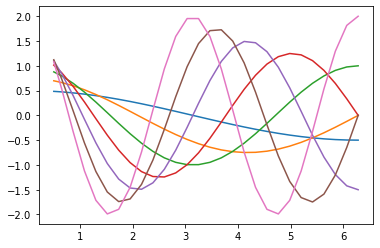

In [35]:
fig, ax = plt.subplots(1, 1)

ia_fixed = 0
for ib in range(result.shape[0]):
    __=ax.plot(xarr, result[ib, ia_fixed, :])

The arguments `a` and `b` can also be vectorized together in situations where these arguments vary within the same dimension

In [36]:
some_func_deriv_vmap3 = jjit(vmap(some_func_deriv_vmap0, in_axes=(None, 0, 0)))

In [37]:
n_b = n_a
b_arr = np.linspace(0.5, 2, n_b)
result = some_func_deriv_vmap3(xarr, a_arr, b_arr)
result.shape

(5, 30)

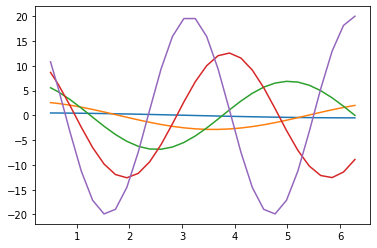

In [38]:
fig, ax = plt.subplots(1, 1)

for iab in range(result.shape[0]):
    __=ax.plot(xarr, result[iab, :])